## Programming Exercise 7

### Setup
This loads the required modules. No other modules are necessary to successfully finish this exercise.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, transform, filters, morphology, img_as_float
from scipy import signal

### 7.1 Canny Edge Detector

The Canny edge detector consists of the following processing steps:
1. Smooth image with Gaussian filter
2. Compute gradient magnitude and angle (Sobel, Prewitt, ...)
3. Apply non-maximum suppression
4. Double thresholding for potential edges
5. Track edges by hysteresis

In the following subtasks, you will implement these steps to create your own Canny edge detector.

#### 7.1.1 

Load the image `building.jpg` from the `resources` folder, convert it to floating point format and transform the color space to grayscale. To speed up the processing speed for the following subtasks, downsample the image by a factor of 2 in width and height using the `transform.downscale_local_mean` function ([docs](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean)). Display the final image.

(2048, 1536)
(1024, 768)


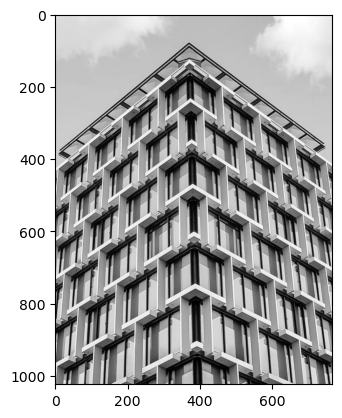

In [2]:
image=color.rgb2gray(img_as_float(io.imread("./resources/building.jpg")))
print(image.shape)
downsampled_image=transform.downscale_local_mean(image,factors=(2,2))
print(downsampled_image.shape)
plt.imshow(downsampled_image,cmap='gray');

#### 7.1.2

Write a function `smooth_gaussian(image, sigma)` that returns a smoothed version of the `image` with a Gaussian filter of standard deviation `sigma`. Display the result of Gaussian smoothing for the image from Subtask 7.1.1 with a standard deviation of `sigma=1`.

*Hint: The `filters.gaussian` function ([docs](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.gaussian)) might be useful.*

(1024, 768)


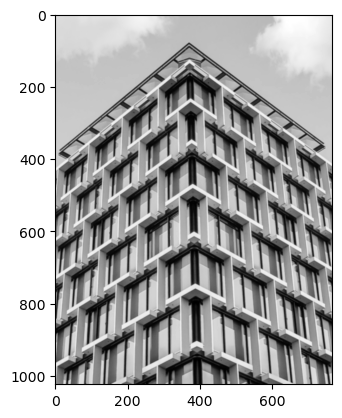

In [3]:
def smooth_gaussian(image,sigma):
    smooth_image=filters.gaussian(image,sigma)
    return smooth_image
smoothed_image=smooth_gaussian(downsampled_image,1)
print(smoothed_image.shape)
plt.imshow(smoothed_image,cmap='gray');

#### 7.1.3

Write a function `sobel_gradient(image)` that returns the gradient magnitude and angle of the image using Sobel filters.

The gradient magnitude $g[m,n]$ is obtained by combining the filtered images $y_0[m,n] = x[m,n] * h_0[m,n]$ and $y_{90}[m, n] = x[m,n] * h_{90}[m,n]$ as

$$g[m,n] = \sqrt{y_0^2[m,n] + y_{90}^2[m,n]},$$

the gradient angle is obtained as

$$\varphi[m,n] = \text{arctan2}(y_0[m,n], y_{90}[m,n]). $$

Normalize the gradient magnitude to a range of 0 to 1, then return both the normalized gradient magnitude and the gradient angle.
Display the results for the smoothed image from Subtask 6.1.2.

*Hint: The `signal.convolve2d` function ([docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html)) function might be useful.*

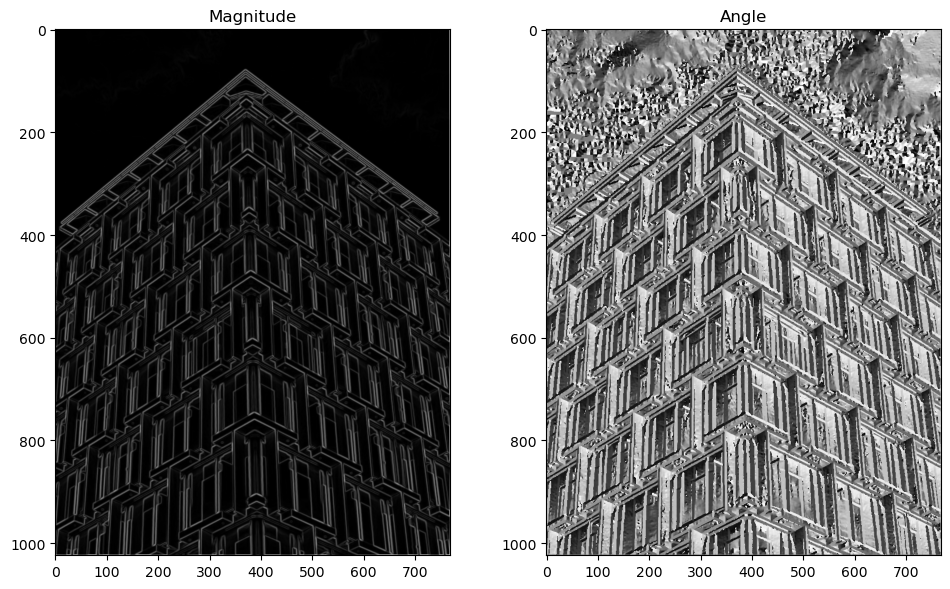

In [17]:
g0=np.array([-1,0,1]).reshape(3,1)
A0=np.array([1,2,1]).reshape(1,-1)
# print(g0.shape,A0.shape)
H0=signal.convolve2d(g0,A0)
H90=signal.convolve2d(A0.T,g0.T)
def sobel_gradient(image):
    y0=signal.convolve2d(image,H0,mode='same')
    y90=signal.convolve2d(image,H90,mode='same')
    magnitude=np.sqrt(np.power(y0,2)+np.power(y90,2))
    mag_normalized=magnitude/np.max(magnitude)
    angle=np.arctan2(y90,y0)
    return mag_normalized,angle

mag,ang=sobel_gradient(smoothed_image)
fig ,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
ax1.imshow(mag,cmap='gray')
ax2.imshow(ang,cmap='gray')
ax1.set_title("Magnitude")
ax2.set_title("Angle")
plt.tight_layout()
plt.show()


#### 7.1.4

In the following, the non-maximum suppression for the gradient magnitude based on the gradient angle is implemented. For each pixel in the gradient, the gradient is only kept if it is larger than either of its neighbours along the edge normal (edge normal is described by the gradient angle), otherwise it is set to 0. To do this efficiently, the edge normals are quantized to four directions. The non-maximum suppression is then performed for each of the four directions sequentially.

Display the results of non-maximum suppressin for the image gradient from Subtask 6.1.3.

[[0.91591126 0.         0.         ... 0.90612646 0.         0.9600476 ]
 [0.         0.00332003 0.00311163 ... 0.         0.         0.90532055]
 [0.8651104  0.00200954 0.         ... 0.         0.         0.90511659]
 ...
 [0.85678414 0.         0.30527566 ... 0.01501912 0.         0.89633887]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.92188498 0.84430391 0.7280849  ... 0.         0.         0.9546691 ]]


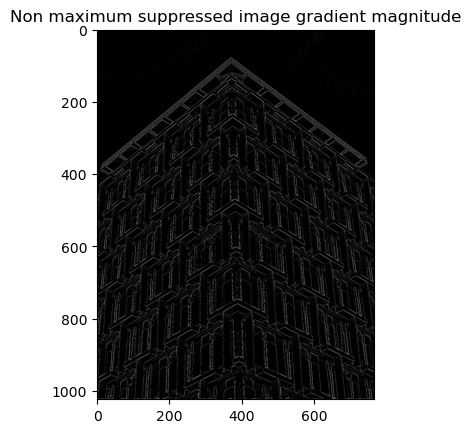

In [32]:
def non_maximum_suppression(gradient_magnitude, gradient_angle):
    # We quantize the edge directions in 4 intervals for simple indexing of edge directions.
    # Thereby, edges rotated by 180° are not differentiated, as it is not important
    # whether an edge describes a change from bright to dark pixels or from dark to bright pixels.
    # After this we have:
    # * value = 0 -> angle = 0
    # * value = 1 -> angle = pi/4
    # * value = 2 -> angle = pi/2
    # * value = 3 -> angle = 3pi/4
    gradient_angle_quantized = np.round(gradient_angle / (np.pi / 4)).astype(int) % 4
    
    # Initialize the non-maximum suppresed gradient magnitude
    gradient_magnitude_suppressed = gradient_magnitude.copy()
    
    # The edge direction offsets as (y_offset, x_offset) for each edge direction
    # Offset at index i corresponds to angle with value i (e.g. index = 1 -> value = 1 -> angle = pi/4)
    edge_dir_offsets = [(0, 1), (1, 1), (1, 0), (1, -1)]
    
    # Pad the original gradient magnitude so we don't get problems at the borders.
    gradient_magnitude_padded = np.pad(gradient_magnitude, 1)
    
    # Loop through all edge directions
    for edge_dir, offset in enumerate(edge_dir_offsets):
        # Get all indices as [[y0, x0], [y1, x1], ...] where the quantized gradient angle matches the currently regarded edge direction.
        indices = np.argwhere(gradient_angle_quantized == edge_dir)
        
        # Add and substract the offset as specified in the edge direction offsets to the indices to get the indices
        # required for checking whether a pixel value is kept or not.
        indices_plus = np.hstack((indices[:, 0].reshape(-1, 1) + offset[0], indices[:, 1].reshape(-1, 1) + offset[1]))
        indices_minus = np.hstack((indices[:, 0].reshape(-1, 1) + offset[0], indices[:, 1].reshape(-1, 1) + offset[1]))
        
        # Check whether the pixel value at index should be kept. For each regarded pixel, this is only the case if the gradient magnitude value at the pixel position
        # is larger than the gradient magnitude value of its neighbors. Thereby, the neighbors are specified using the edge direction offset, which is based on the
        # gradient angle. As after this offset, pixels might be addressed that are out-of-bounds, the padded gradient magnitude is accessed to avoid accessing invalid memory.
        condition_keep_plus = (gradient_magnitude[indices[:, 0], indices[:, 1]] > gradient_magnitude_padded[indices_plus[:, 0] + 1, indices_plus[:, 1] + 1])
        condition_keep_minus = (gradient_magnitude[indices[:, 0], indices[:, 1]] > gradient_magnitude_padded[indices_minus[:, 0] + 1, indices_minus[:, 1] + 1])
        condition_keep = condition_keep_plus & condition_keep_minus
        
        # The entries in the non-maximum suppressed gradient magnitude are either taken over from the original gradient magnitude (if condition_keep==True)
        # or replaced by 0 (if condition_keep==False)
        gradient_magnitude_suppressed[indices[:, 0], indices[:, 1]] = np.where(condition_keep, gradient_magnitude[indices[:, 0], indices[:, 1]], 0)
    
    return gradient_magnitude_suppressed
    
# Execute non-maximum suppression and display result...
nms_mag=non_maximum_suppression(mag,ang)
print(nms_mag)
plt.imshow(nms_mag,cmap='gray')
plt.title("Non maximum suppressed image gradient magnitude")
plt.show()

#### 7.1.5

Write a function `double_thresholding(gradient_magnitude, threshold_low, threshold_high)` that returns the potential edge map for the given gradient magnitude image. Gradient pixels that surpass `threshold_high` should be marked as definitive edges (`1`), pixels that lie between `threshold_low` and `threshold_high` as potential edges (`0.5`) and all others as no edges (`0`). Display the results for the non-maximum suppressed image gradient from Subtask 7.1.4 with `threshold_high=0.2` and `threshold_low = 0.4 * threshold_high`.

[[1. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 1. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 1.]]
69167
66477
650788


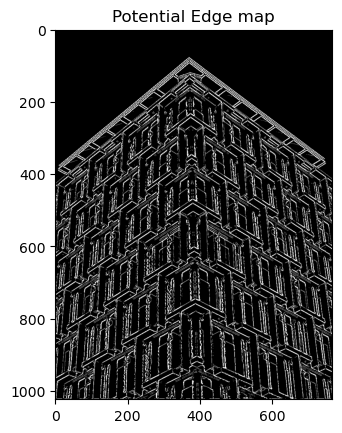

In [37]:
def double_thresholding(gradient_magnitude,threshold_low,threshold_high):
    edge_map=np.where(gradient_magnitude>threshold_high,1,np.where(gradient_magnitude<threshold_low,0,0.5))
    return edge_map

potential_edgemap=double_thresholding(nms_mag,0.4*0.2,0.2)
print(potential_edgemap)
print(np.sum(potential_edgemap==0.5))
print(np.sum(potential_edgemap==1))
print(np.sum(potential_edgemap==0))
plt.imshow(potential_edgemap,cmap='gray')
plt.title("Potential Edge map")
plt.show()


#### 7.1.6

Write a function `edge_hysteresis(potential_edgemap)` that decides whether a potential edge is counted as an edge or not by checking whether it is 8-connected to a strong edge. If it is, mark it as a strong edge. Do this iteratively until no further changes occur. Display the results for the potential edge map from Subtask 6.1.5.

*Hint: The usage of a morphological operation could be useful.*

0
101245
685187


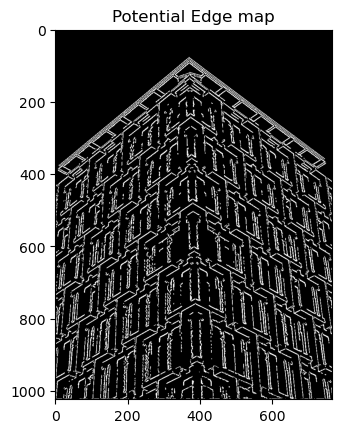

In [38]:
from scipy.ndimage import binary_dilation
def edge_hysteresis(potential_edgemap):
    strong_mask=(potential_edgemap==1)
    potential_edge=(potential_edgemap==0.5)
    struct=np.ones((3,3),dtype=bool)
    dilated_strong=binary_dilation(strong_mask,structure=struct)
    weak_to_strong=dilated_strong&potential_edge
    strong_edgemap=np.where(weak_to_strong|strong_mask,1,0)
    return strong_edgemap
strong_edgemap=edge_hysteresis(potential_edgemap)
print(np.sum(strong_edgemap==0.5))
print(np.sum(strong_edgemap==1))
print(np.sum(strong_edgemap==0))
plt.imshow(strong_edgemap,cmap='gray')
plt.title("Potential Edge map")
plt.show()

#### 7.1.7

**Congratulations!** You implemented all processing steps that are necessary for the Canny Edge detection algorithm. To finish, compile the different steps into a joint function `canny_edge_detection(image, sigma, threshold_low, threshold_high)` and try to find a good set of parameters for the current image. Display the results.

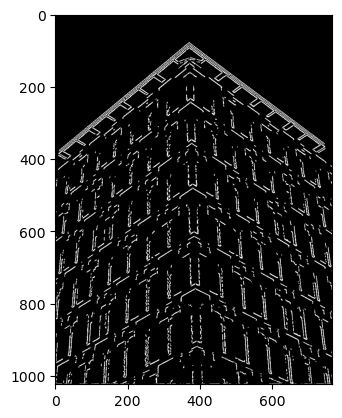

In [47]:
def canny_edge_detection(image,sigma,threshold_low,threshold_high):
    smoothed_image=smooth_gaussian(image,sigma)
    magnitude,angle=sobel_gradient(smoothed_image)
    nms_mag=non_maximum_suppression(magnitude,angle)
    thresholded_image=double_thresholding(nms_mag,threshold_low,threshold_high)
    edgemap=edge_hysteresis(thresholded_image)
    return edgemap

edge_detected=canny_edge_detection(downsampled_image,1,0.09,0.3)
plt.imshow(edge_detected,cmap='gray') 
plt.show()